## Apply all imports here

In [1]:
from os import listdir, getcwd
import os
from os.path import isfile, join
import subprocess
import sys
import csv
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
import ast
import re
import json
import statistics
import numpy as np


## Read all csv files 

In [2]:
mypath_soot = join(getcwd(), 'eval_results/soot_res')
mypath_sootup = join(getcwd(), 'eval_results/sootup_res')
# print(mypath)

csv_files_soot = [f for f in listdir(mypath_soot) if isfile(join(mypath_soot, f))]
csv_files_sootup = [f for f in listdir(mypath_sootup) if isfile(join(mypath_sootup, f))]
print(csv_files_soot)
print(csv_files_sootup)

# csv_files_soot = ['soot_ide_eval_vm_merged.csv']
# csv_files_soot = ['convert_soot_commatosemicolon.csv']
# csv_files_sootup = ['sootUp_ide_eval_mix_vm_1.csv']
csv_files_soot = ['soot_ide_eval_mix_vm_individualbt.csv']
csv_files_sootup = ['sootUp_ide_eval_mix_vm_individualbi.csv']


completepaths_soot = [os.path.join(mypath_soot, f) for f in csv_files_soot]
completepaths_sootup = [os.path.join(mypath_sootup, f) for f in csv_files_sootup]
# print(completepaths)

desired_col_soot = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyTransformers","BodyTransformersMetrics"]
desired_col_sootup = ["jar","solver","thread","totalRuntime","cgConstructionTime","prop","method","mem","CallGraphAlgo","callGraphEdges","callGraphReachableNodes","initialStmtCount","stmtCountAfterApplyingBI","BodyInterceptors","BodyInterceptorsMetrics"]

for completefilepath_soot in completepaths_soot:
    df_soot = pd.read_csv(completefilepath_soot, sep=";")

for completefilepath_sootup in completepaths_sootup:
    df_sootup = pd.read_csv(completefilepath_sootup, sep=";")

df_soot.columns = desired_col_soot
df_sootup.columns = desired_col_sootup


def apply_complex_function1(x):
    return list(map(str.strip, x['BodyTransformers'].strip('[]').split(',')))

def apply_complex_function2(x):
    return list(map(str.strip, x['BodyInterceptors'].strip('[]').split(',')))

def convert_to_dict1(metric_str):
    metric_str['BodyTransformersMetrics'] = re.sub(r'(\b[\w.-]+\b)(?=\s*=\s*\[)', r'"\1"', metric_str['BodyTransformersMetrics'])  # Quote keys
    metric_str['BodyTransformersMetrics'] = metric_str['BodyTransformersMetrics'].replace('=', ':').replace('[', '[').replace(']', ']')
    return json.loads(metric_str['BodyTransformersMetrics'].replace("'", '"'))

def convert_to_dict2(metric_str):
    # Replace '=' with ':' and add double quotes around the keys
    metric_str['BodyInterceptorsMetrics'] = re.sub(r'@[\w]+', '', metric_str['BodyInterceptorsMetrics'])
    metric_str['BodyInterceptorsMetrics'] = re.sub(r'([\w\.]+)=', r'"\1":', metric_str['BodyInterceptorsMetrics'])
    metric_str['BodyInterceptorsMetrics'] = metric_str['BodyInterceptorsMetrics'].replace('=', ':').replace('[', '[').replace(']', ']')
    return json.loads(metric_str['BodyInterceptorsMetrics'].replace("'", '"'))

key_mapping = {
    'sootup.interceptors.TypeAssigner': 'jb.tr',
    'sootup.interceptors.DeadAssignmentEliminator': 'jb.dae',
    'sootup.interceptors.UnusedLocalEliminator': 'jb.ule',
    'sootup.interceptors.LocalSplitter': 'jb.ls',
    'sootup.interceptors.LocalPacker': 'jb.lp',
    'sootup.interceptors.CopyPropagator': 'jb.cp',
    'sootup.interceptors.Aggregator': 'jb.a',
    'sootup.interceptors.EmptySwitchEliminator': 'jb.ese',
    'sootup.interceptors.ConditionalBranchFolder': 'jb.cbf',
    'sootup.interceptors.NopEliminator': 'jb.ne',
    'sootup.interceptors.LocalNameStandardizer': 'jb.lns',
    'sootup.interceptors.UnreachableCodeEliminator': 'jb.uce'
}

def replace_keys_in_dict(original_dict):
    new_dict = {}
    for old_key, value in original_dict['BodyInterceptorsMetrics'].items():
        # Use the mapping to replace the key if it exists in the mapping
        new_key = key_mapping.get(old_key, old_key)  # If not in mapping, keep original key
        new_dict[new_key] = value
    return new_dict
    
df_soot['BodyTransformers'] = df_soot.apply(apply_complex_function1, axis=1)
df_sootup['BodyInterceptors'] = df_sootup.apply(apply_complex_function2, axis=1)
df_soot['BodyTransformersMetrics'] = df_soot.apply(convert_to_dict1, axis=1)
df_sootup['BodyInterceptorsMetrics'] = df_sootup.apply(convert_to_dict2, axis=1)
df_sootup['BodyInterceptorsMetrics'] = df_sootup.apply(replace_keys_in_dict, axis=1)


df_soot['stmtCountAfterApplyingBI'] = pd.to_numeric(df_soot['stmtCountAfterApplyingBI'], errors='coerce')
df_soot['initialStmtCount'] = pd.to_numeric(df_soot['initialStmtCount'], errors='coerce')
df_soot['totalRuntime'] = pd.to_numeric(df_soot['totalRuntime'], errors='coerce')
df_soot['cgConstructionTime'] = pd.to_numeric(df_soot['cgConstructionTime'], errors='coerce')
df_soot['prop'] = pd.to_numeric(df_soot['prop'], errors='coerce')
df_soot['method'] = pd.to_numeric(df_soot['method'], errors='coerce')
df_soot['mem'] = pd.to_numeric(df_soot['mem'], errors='coerce')
df_soot['callGraphEdges'] = pd.to_numeric(df_soot['callGraphEdges'], errors='coerce')
df_soot['callGraphReachableNodes'] = pd.to_numeric(df_soot['callGraphReachableNodes'], errors='coerce')


df_sootup['stmtCountAfterApplyingBI'] = pd.to_numeric(df_sootup['stmtCountAfterApplyingBI'], errors='coerce')
df_sootup['initialStmtCount'] = pd.to_numeric(df_sootup['initialStmtCount'], errors='coerce')
df_sootup['totalRuntime'] = pd.to_numeric(df_sootup['totalRuntime'], errors='coerce')
df_sootup['cgConstructionTime'] = pd.to_numeric(df_sootup['cgConstructionTime'], errors='coerce')
df_sootup['prop'] = pd.to_numeric(df_sootup['prop'], errors='coerce')
df_sootup['method'] = pd.to_numeric(df_sootup['method'], errors='coerce')
df_sootup['mem'] = pd.to_numeric(df_sootup['mem'], errors='coerce')
df_sootup['callGraphEdges'] = pd.to_numeric(df_sootup['callGraphEdges'], errors='coerce')
df_sootup['callGraphReachableNodes'] = pd.to_numeric(df_sootup['callGraphReachableNodes'], errors='coerce')


# Ensure that BodyTransformers column contains tuples
df_soot['BodyTransformers'] = df_soot['BodyTransformers'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
df_sootup['BodyInterceptors'] = df_sootup['BodyInterceptors'].apply(lambda x: tuple(x) if isinstance(x, list) else x)

# Function to sum the first value from each list in BodyInterceptorsMetrics
def calculate_bi_total_time(metrics):
    if isinstance(metrics, dict):  # Check if it's a dictionary
        total_time = sum(value[0] for key, value in metrics.items() if isinstance(value, list) and len(value) > 0)
        return total_time
    return 0  # Return 0 if BodyInterceptorsMetrics is not a dictionary or has no valid data

# Apply the function to create a new column 'BITotalTime'
df_soot['BITotalTime'] = df_soot['BodyTransformersMetrics'].apply(calculate_bi_total_time)
df_sootup['BITotalTime'] = df_sootup['BodyInterceptorsMetrics'].apply(calculate_bi_total_time)

# df_soot['BodyTransformers'][1]
# df_soot['BodyTransformersMetrics'][1].keys()
# df_sootup['BodyInterceptors'][1]
# df_sootup['BodyInterceptorsMetrics'][1].keys()


['convert_soot_commatosemicolon.csv', 'extra4jars.csv', 'soot_ide_eval_CHA_20_run1.csv', 'soot_ide_eval_CHA_20_run2_hp.csv', 'soot_ide_eval_mix_run3_hp.csv', 'soot_ide_eval_mix_vm_individualbt.csv', 'soot_ide_eval_RTA_17_run1.csv', 'soot_ide_eval_RTA_17_run2.csv', 'soot_ide_eval_vm_cha_1.csv', 'soot_ide_eval_vm_merged.csv', 'soot_ide_eval_vm_mix_1.csv', 'soot_ide_eval_vm_mix_2.csv', 'soot_ide_eval_vm_rta_1.csv']
['extra4jarssootup.csv', 'sootUp_ide_eval_CHA_13_run1.csv', 'sootUp_ide_eval_mix_vm_1.csv', 'sootUp_ide_eval_mix_vm_individualbi.csv', 'sootUp_ide_eval_RTA_13_run1.csv']


In [3]:
df_soot.iloc[0:1]

,jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyTransformers,BodyTransformersMetrics,BITotalTime
0,assertj-core-3.24.2,default,1,62110.0,6085.0,3020975.0,50.0,594.0,CHA,57910.0,13599.0,101912.0,102790.0,"(JB_LS, JB_TR, JB_LP)","{'jb.tr': [1424, 2], 'jb.lp': [697, -126], 'jb...",2852


In [28]:
df_sootup.iloc[0:1]

,jar,solver,thread,totalRuntime,cgConstructionTime,prop,method,mem,CallGraphAlgo,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,BodyInterceptors,BodyInterceptorsMetrics,BITotalTime
0,slf4j-reload4j-2.0.7,default,1,689,131,0,50,34,CHA,101,93,295,316,"(JB_LS, JB_TR, JB_LP, JB_ULE, JB_CP, JB_ESE, J...","{'jb.tr': [239, 2], 'jb.lp': [100, 0], 'jb.ese...",403


## Grouped data

In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict


df_soot_analysis = pd.DataFrame({
    'jar': df_soot['jar'],
    'cgConstructionTime': df_soot['cgConstructionTime'],
    'CallGraphAlgo': df_soot['CallGraphAlgo'],
    'callGraphEdges': df_soot['callGraphEdges'],
    'callGraphReachableNodes': df_soot['callGraphReachableNodes'],
    'stmtDiff': df_soot['stmtCountAfterApplyingBI'] - df_soot['initialStmtCount'],
    'initialStmtCount': df_soot['initialStmtCount'],
    'stmtCountAfterApplyingBI': df_soot['stmtCountAfterApplyingBI'],
    'BITotalTime': df_soot['BITotalTime'],
    'BodyTransformers': df_soot['BodyTransformers'],
    'BodyTransformersMetrics': df_soot['BodyTransformersMetrics'],
    'totalRuntime': df_soot['totalRuntime'],
    'prop': df_soot['prop'],
    'mem': df_soot['mem']
})

df_sootup_analysis = pd.DataFrame({
    'jar': df_sootup['jar'],
    'cgConstructionTime': df_sootup['cgConstructionTime'],
    'CallGraphAlgo': df_sootup['CallGraphAlgo'],
    'callGraphEdges': df_sootup['callGraphEdges'],
    'callGraphReachableNodes': df_sootup['callGraphReachableNodes'],
    'stmtDiff': df_sootup['stmtCountAfterApplyingBI'] - df_sootup['initialStmtCount'],
    'initialStmtCount': df_sootup['initialStmtCount'],
    'stmtCountAfterApplyingBI': df_sootup['stmtCountAfterApplyingBI'],
    'BITotalTime': df_sootup['BITotalTime'],
    'BodyInterceptors': df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': df_sootup['BodyInterceptorsMetrics'],
    'totalRuntime': df_sootup['totalRuntime'],
    'prop': df_sootup['prop'],
    'mem': df_sootup['mem']
})

df_soot_analysis = df_soot_analysis[df_soot_analysis['CallGraphAlgo'] == 'CHA']
df_sootup_analysis = df_sootup_analysis[df_sootup_analysis['CallGraphAlgo'] == 'CHA']

# Function to aggregate the dictionaries with average of lists
def aggregate_dicts(dicts):
    aggregated = defaultdict(list)
    # Combine all the lists for each key
    for d in dicts:
        for key, values in d.items():
            if key in aggregated:
                aggregated[key] = [x + y for x, y in zip(aggregated[key], values)]
            else:
                aggregated[key] = values[:]
    # Take the average for each list
    for key, values in aggregated.items():
        count = len(dicts)
        aggregated[key] = [round(val / count, 2) for val in values]
    return dict(aggregated)

# Group by (jar, BodyInterceptors) and aggregate the values
grouped_df_soot = df_soot_analysis.groupby(['jar', 'BodyTransformers'], as_index=False).agg({
    'BodyTransformersMetrics': lambda x: aggregate_dicts(x),
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'initialStmtCount': 'mean',
    'stmtCountAfterApplyingBI': 'mean',
    'stmtDiff': 'mean',
    'totalRuntime': 'mean',
    'prop': 'mean',
    'mem': 'mean'
}).reset_index()


grouped_df_sootup = df_sootup_analysis.groupby(['jar', 'BodyInterceptors'], as_index=False).agg({
    'BodyInterceptorsMetrics': lambda x: aggregate_dicts(x),
    'cgConstructionTime': 'mean',  # Example: You can aggregate other columns like cgConstructionTime
    'callGraphEdges': 'mean',      # Example: Aggregate callGraphEdges by mean (or other function)
    'callGraphReachableNodes': 'mean',
    'initialStmtCount': 'mean',
    'stmtCountAfterApplyingBI': 'mean',
    'stmtDiff': 'mean',
    'totalRuntime': 'mean',
    'prop': 'mean',
    'mem': 'mean'
})

# Function to sum the first value from each list in BodyInterceptorsMetrics
def calculate_bi_total_time(metrics):
    if isinstance(metrics, dict):  # Check if it's a dictionary
        total_time = sum(value[0] for key, value in metrics.items() if isinstance(value, list) and len(value) > 0)
        return total_time
    return 0  # Return 0 if BodyInterceptorsMetrics is not a dictionary or has no valid data

# BI Total Time is for the grouped average now
# Apply the function to create a new column 'BITotalTime'
grouped_df_soot['BITotalTime'] = grouped_df_soot['BodyTransformersMetrics'].apply(calculate_bi_total_time)
grouped_df_sootup['BITotalTime'] = grouped_df_sootup['BodyInterceptorsMetrics'].apply(calculate_bi_total_time)


# Display the resulting DataFrame
# print(grouped_df_soot)
# print(grouped_df_sootup)


In [31]:
setofjarsinsoot = set()
# iterate through specific columns of the dataframe
for index, row in df_soot_analysis.loc[:, ['jar','BodyTransformers']].iterrows():
    setofjarsinsoot.add(tuple(row['jar']))
    # print(row['callGraphEdges'], row['BodyInterceptors'])

print(len(setofjarsinsoot))

setofjarsinsootup = set()
# iterate through specific columns of the dataframe
for index, row in df_sootup_analysis.loc[:, ['jar','BodyInterceptors']].iterrows():
    setofjarsinsootup.add(tuple(row['jar']))
    # print(row['callGraphEdges'], row['BodyInterceptors'])

print(len(setofjarsinsootup))

20
14


In [4]:
# df_soot_analysis.iloc[0:1]
grouped_df_soot.iloc[0:1]

,index,jar,BodyTransformers,BodyTransformersMetrics,cgConstructionTime,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,stmtDiff,totalRuntime,prop,mem,BITotalTime
0,0,commons-codec-1.15,"(JB_LS, JB_TR)","{'jb.tr': [1525.33, -17.67], 'jb.ls': [852.0, ...",3606.0,7210.0,1963.0,27946.0,24432.0,-3514.0,17184.333333,356652.0,326.333333,2377.33


In [5]:
# df_sootup_analysis.iloc[0:1]
grouped_df_sootup.iloc[0:1]

,jar,BodyInterceptors,BodyInterceptorsMetrics,cgConstructionTime,callGraphEdges,callGraphReachableNodes,initialStmtCount,stmtCountAfterApplyingBI,stmtDiff,totalRuntime,prop,mem,BITotalTime
0,commons-codec-1.15,"(JB_LS, JB_TR)","{'jb.ls': [209.0, 41.33], 'jb.tr': [1448.0, -8...",296.0,4455.0,1187.0,20198.0,20583.0,385.0,14232.666667,126417.333333,465.0,1657.0


## Correlation Matrix

In [71]:
# df = pd.DataFrame(df_soot_analysis)
# df = pd.DataFrame(grouped_df_sootup)


# # Convert 'BodyInterceptors' column into one-hot encoded (binary) columns
# # df_encoded = pd.get_dummies(df['BodyTransformers'].apply(lambda x: ','.join(x)))
# df_encoded = pd.get_dummies(df['BodyInterceptors'].apply(lambda x: ','.join(x)))


# # Combine the encoded columns with the original dataframe
# df_combined = pd.concat([df, df_encoded], axis=1)

# # Drop non-numeric columns (like 'jar' and 'type')
# # df_combined = df_combined.drop(['jar', 'BodyTransformers'], axis=1)
# df_combined = df_combined.drop(['jar', 'BodyInterceptors'], axis=1)


# # Select numerical columns for correlation
# numerical_cols = ['BITotalTime', 'cgConstructionTime', 'callGraphEdges', 'stmtDiff'] + list(df_encoded.columns)
# # Compute the correlation matrix
# correlation_matrix = df_combined[numerical_cols].corr()

# # Filter correlations to show only those >= 0.7 or <= -0.7
# filtered_corr_matrix = correlation_matrix.map(lambda x: x if abs(x) >= 0.6 else np.nan)

# # Plot the heatmap
# plt.figure(figsize=(12, 8))
# sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, mask=filtered_corr_matrix.isnull())
# # sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
# plt.title('Filtered Correlation Heatmap (|corr| >= 0.6)')
# plt.show()

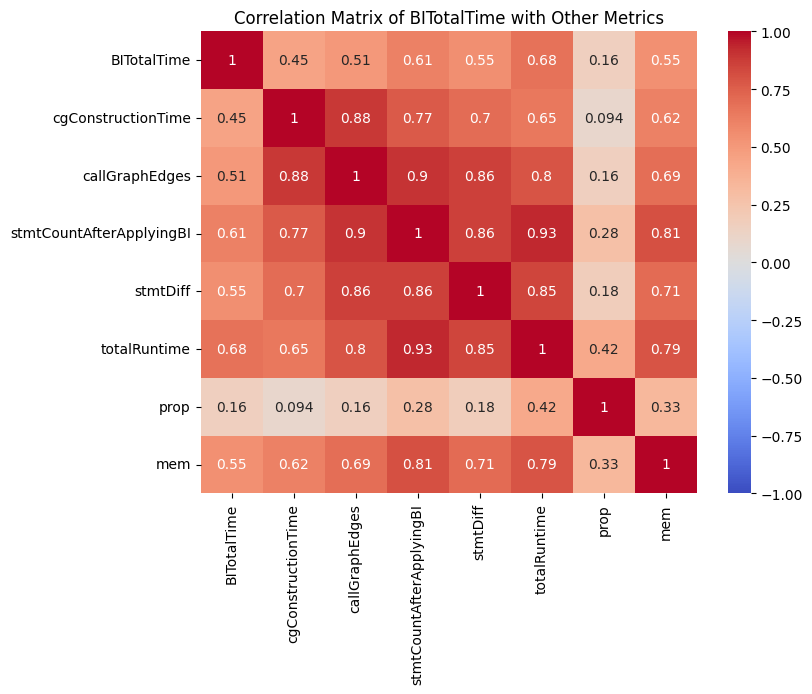

In [6]:
# Create DataFrame
# df = pd.DataFrame(grouped_df_soot)
df = pd.DataFrame(grouped_df_sootup)

# Select numerical columns for correlation
numerical_cols = ['BITotalTime', 'cgConstructionTime', 'callGraphEdges', 'stmtCountAfterApplyingBI', 'stmtDiff', 'totalRuntime', 'prop', 'mem']

# Compute the correlation matrix
corr_matrix = df[numerical_cols].corr()

# Filter correlations to show only those >= 0.7 or <= -0.7
filtered_corr_matrix = corr_matrix.map(lambda x: x if abs(x) >= 0.6 else np.nan)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of BITotalTime with Other Metrics')
plt.show()


# ===================== RQ2 ==========================

## IF YOU WANT TO COMPARE INDIVIDUAL BODY INTERCEPTOR THEN RUN WITH JUST INDIVIDUAL INTERCEPTOR but (jb.ls, jb,tr) mandatory

### Average of all jars Runtime

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Sample Data
df_soot_allavg = pd.DataFrame({
    'BodyInterceptors': grouped_df_soot['BodyTransformers'],
    'BodyTransformersMetrics': grouped_df_soot['BodyTransformersMetrics']
})

df_sootup_allavg = pd.DataFrame({
    'BodyInterceptors': grouped_df_sootup['BodyInterceptors'],
    'BodyInterceptorsMetrics': grouped_df_sootup['BodyInterceptorsMetrics']
})

# Add a 'type' column to differentiate between soot and sootup
df_soot_allavg['type'] = 'soot'
df_sootup_allavg['type'] = 'sootup'

# Combine both DataFrames
df_combined_avg = pd.concat([df_soot_allavg, df_sootup_allavg])

# Create DataFrame
df = pd.DataFrame(df_combined_avg)


## Individual Jars wrt cgConstructionTime, callGraphEdges, callGraphReachableNodes, stmtDiff, totalRuntime, mem, prop

#### cgConstructionTime

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_cgConstructionTime'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher cgConstructionTime than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='cgConstructionTime').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher cgConstructionTime than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('cgConstructionTime', fontsize=12)
    ax.set_title(f'cgConstructionTime for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher cgConstructionTime than sootup
print(f"Number of jars where soot has a higher cgConstructionTime than sootup: {soot_higher_count}")

Number of jars where soot has a higher cgConstructionTime than sootup: 21


#### callGraphEdges

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_callGraphEdges'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher callGraphEdges than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='callGraphEdges').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher callGraphEdges than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('callGraphEdges', fontsize=12)
    ax.set_title(f'callGraphEdges for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher callGraphEdges than sootup
print(f"Number of jars where soot has a higher callGraphEdges than sootup: {soot_higher_count}")

Number of jars where soot has a higher callGraphEdges than sootup: 21


#### callGraphReachableNodes

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_callGraphReachableNodes'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher callGraphReachableNodes than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='callGraphReachableNodes').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher callGraphReachableNodes than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('callGraphReachableNodes', fontsize=12)
    ax.set_title(f'callGraphReachableNodes for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher callGraphReachableNodes than sootup
print(f"Number of jars where soot has a higher callGraphReachableNodes than sootup: {soot_higher_count}")

Number of jars where soot has a higher callGraphReachableNodes than sootup: 21


#### stmtDiff

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_stmtDiff'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher stmtDiff than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='stmtDiff').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher stmtDiff than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('stmtDiff', fontsize=12)
    ax.set_title(f'stmtDiff for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher stmtDiff than sootup
print(f"Number of jars where soot has a higher stmtDiff than sootup: {soot_higher_count}")

Number of jars where soot has a higher stmtDiff than sootup: 1


#### totalRuntime

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_totalRuntime'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher totalRuntime than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='totalRuntime').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher totalRuntime than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('totalRuntime', fontsize=12)
    ax.set_title(f'totalRuntime for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher totalRuntime than sootup
print(f"Number of jars where soot has a higher totalRuntime than sootup: {soot_higher_count}")

Number of jars where soot has a higher totalRuntime than sootup: 19


#### mem

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_mem'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher mem than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='mem').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher mem than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('totalmemory', fontsize=12)
    ax.set_title(f'totalmemory for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher mem than sootup
print(f"Number of jars where soot has a higher totalmem than sootup: {soot_higher_count}")

Number of jars where soot has a higher totalmem than sootup: 15


#### prop

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory to save the plots
output_directory = r'C:\Users\sahil\Documents\master-thesis\thesis_fig\RQ2\individual_jar_prop'
os.makedirs(output_directory, exist_ok=True)  # Create the directory if it doesn't exist

# Ensure consistent column names for BodyTransformers/BodyInterceptors
grouped_df_soot.rename(columns={'BodyTransformers': 'BodyInterceptors'}, inplace=True)

# Add a 'type' column to differentiate between soot and sootup
grouped_df_soot['type'] = 'soot'
grouped_df_sootup['type'] = 'sootup'

# Combine both DataFrames
df_combined = pd.concat([grouped_df_soot, grouped_df_sootup])

# Variable to count the number of jars where soot has a higher prop than sootup
soot_higher_count = 0

# Group the combined dataframe by 'jar' and 'BodyTransformers'
for jar in df_combined['jar'].unique():
    # Filter data for the current jar
    df_jar = df_combined[df_combined['jar'] == jar]
    
    # Pivot the data for comparison
    df_pivot = df_jar.pivot(index='BodyInterceptors', columns='type', values='prop').fillna(0)

    # Ensure both 'soot' and 'sootup' exist in df_pivot, handle cases where one might be missing
    if 'soot' not in df_pivot.columns:
        df_pivot['soot'] = 0
    if 'sootup' not in df_pivot.columns:
        df_pivot['sootup'] = 0

    # Check if soot has higher prop than sootup for the current jar
    if df_pivot['soot'].mean() > df_pivot['sootup'].mean():
        soot_higher_count += 1

    # Plot the data
    x = np.arange(len(df_pivot))  # the label locations
    width = 0.35  # the width of the bars
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create bars for soot and sootup
    rects1 = ax.bar(x - width/2, df_pivot['soot'], width, label='Soot', color='skyblue')
    rects2 = ax.bar(x + width/2, df_pivot['sootup'], width, label='SootUp', color='orange')
    
    # Add labels and title
    ax.set_xlabel('BodyInterceptors', fontsize=12)
    ax.set_ylabel('propagations', fontsize=12)
    ax.set_title(f'propagations for Soot vs SootUp in {jar}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_pivot.index.astype(str), rotation=45, ha='right')
    ax.legend()

    # Function to label the bars with their heights
    def autolabel(rects):
        """Attach a text label above each bar in rects, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)
    
    # Adjust layout and show the plot
    fig.tight_layout()
    # plt.show()
    plot_filename = os.path.join(output_directory, f'{jar}_performance_comparison.png')
    plt.savefig(plot_filename)
    # Clear the figure to avoid overlapping of plots in the next iteration
    plt.close(fig)

# Output the count of jars where soot has a higher prop than sootup
print(f"Number of jars where soot has a higher prop than sootup: {soot_higher_count}")

Number of jars where soot has a higher prop than sootup: 17
